## **Collecting Data**

In [44]:
from Bio import Entrez
import pandas as pd
import time
from datetime import datetime

Entrez.email = "meghsuhanths2306@gmail.com"

def collect_pubmed_fixed(search_term, max_results=100):
    """
    Fixed PubMED collection with proper XML handling
    """

    print(f"Collecting articles for: {search_term}")


    #Searching for PMIDs
    try:
        handle = Entrez.esearch(
            db="pubmed",
            term=search_term,
            retmax=max_results,
            sort="relevance"
        )

        results = Entrez.read(handle)
        handle.close()

        pmids = results['IdList']
        total_count = int(results['Count'])

        print(f"Found {total_count} total articles")
        print(f"Retrieving {len(pmids)} articles\n")

        if len(pmids) == 0:
            print("No PMIDs found!")
            return []

    except Exception as e:
        print(f"Search failed: {e}")
        return []

    #Fetching abstracts
    print("Step 2: Fetching article details...")
    articles = []
    batch_size = 50

    for i in range(0, len(pmids), batch_size):
        batch_pmids = pmids[i:i+batch_size]
        batch_num = (i // batch_size) + 1
        total_batches = (len(pmids) + batch_size - 1) // batch_size

        print(f"  Fetching batch {batch_num}/{total_batches} ({len(batch_pmids)} articles)...")

        try:

            handle = Entrez.efetch(
                db="pubmed",
                id=batch_pmids,
                rettype="abstract",
                retmode="xml"
            )
            records = Entrez.read(handle)
            handle.close()

            # Processing each article
            for record in records['PubmedArticle']:
                try:
                    medline_citation = record['MedlineCitation']
                    article = medline_citation['Article']

                    # Extracting PMID, title, abstract, journal, publication date, author
                    pmid = str(medline_citation['PMID'])
                    title = article.get('ArticleTitle', '')

                    abstract = ''
                    if 'Abstract' in article:
                        abstract_texts = article['Abstract'].get('AbstractText', [])
                        # Joining all abstract parts
                        abstract = ' '.join([str(text) for text in abstract_texts])

                    journal = article.get('Journal', {}).get('Title', '')

                    # Extracting publication date
                    pub_date = ''
                    if 'Journal' in article and 'JournalIssue' in article['Journal']:
                        pub_info = article['Journal']['JournalIssue'].get('PubDate', {})
                        year = pub_info.get('Year', '')
                        month = pub_info.get('Month', '')
                        pub_date = f"{year}-{month}" if year else ''

                    authors = []
                    if 'AuthorList' in article:
                        for author in article['AuthorList']:
                            if 'LastName' in author:
                                name = f"{author.get('LastName', '')} {author.get('Initials', '')}"
                                authors.append(name.strip())

                    # Only keep if we have an abstract
                    if abstract and len(abstract) > 50:
                        article_data = {
                            'pmid': pmid,
                            'title': title,
                            'abstract': abstract,
                            'journal': journal,
                            'publication_date': pub_date,
                            'authors': ', '.join(authors),
                            'num_authors': len(authors),
                            'abstract_length': len(abstract)
                        }
                        articles.append(article_data)

                except Exception as e:
                    print(f"    Warning: Skipped one article: {str(e)[:50]}")
                    continue

            print(f"  Collected {len(articles)} articles so far")
            time.sleep(0.4)

        except Exception as e:
            print(f"    Batch {batch_num} failed: {e}")
            continue

    print(f"\n Collection complete: {len(articles)} articles with abstracts\n")
    return articles

In [51]:
def collect_medical_specialities(max_per_speciality=1000):
    """
    Collect data for all medical specialties
    """
    
    import os
    os.makedirs('data_specialities_checkpoints', exist_ok=True)
    
    # Medical specialities
    specialities = {
        'cardiology': 'cardiology AND 2020:2024[DP] AND English[LA]',
        'diabetes': 'diabetes mellitus AND 2020:2024[DP] AND English[LA]',
        'infectious_diseases': 'infectious diseases AND 2020:2024[DP] AND English[LA]',
        'neurology': 'neurology AND 2020:2024[DP] AND English[LA]',
        'pulmonology': 'pulmonology AND 2020:2024[DP] AND English[LA]',
        'oncology': 'oncology AND 2020:2024[DP] AND English[LA]',
        'nephrology': 'nephrology AND 2020:2024[DP] AND English[LA]',
        'gastroenterology': 'gastroenterology AND 2020:2024[DP] AND English[LA]'
    }
    
    all_articles = []
    
    for speciality_name, query in specialities.items():
        print(f"COLLECTING: {speciality_name.upper()}")
        
        # Collecting articles
        articles = collect_pubmed_fixed(query, max_results=max_per_speciality)
        
        # Adding specialty label
        for article in articles:
            article['specialty'] = speciality_name
            article['collection_date'] = datetime.now().strftime('%Y-%m-%d')
        
        all_articles.extend(articles)
        
        print(f"\n{speciality_name}: {len(articles)} articles collected")
        print(f"Total so far: {len(all_articles)} articles\n")
        
        # Saving checkpoint in folder
        checkpoint_df = pd.DataFrame(articles)
        checkpoint_df.to_csv(f'data_specialities_checkpoints/{speciality_name}_checkpoint.csv', index=False)
        print(f"Checkpoint saved: data_specialities_checkpoints/{speciality_name}_checkpoint.csv\n")
        
        time.sleep(2)
    
    return all_articles

automatically saves checkpoints. So, we can stop whenever we want

In [54]:
medical_data = collect_medical_specialities(max_per_speciality=1000)

df_final = pd.DataFrame(medical_data)

# Saving dataset
df_final.to_csv('medical_literature_dataset.csv', index=False)
df_final.to_json('medical_literature_dataset.json', orient='records', indent=2)

print("COLLECTION COMPLETE")
print(f"\nTotal articles: {len(df_final)}")
print(f"\nSpecialty distribution:")
print(df_final['specialty'].value_counts())
print(f"\nFiles saved:")
print("medical_literature_dataset.csv")
print("medical_literature_dataset.json")

COLLECTING: CARDIOLOGY
Found 222697 total articles
Retrieving 1000 articles

Step 2: Fetching article details...
  Fetching batch 1/20 (50 articles)...
  Collected 25 articles so far
  Fetching batch 2/20 (50 articles)...
  Collected 55 articles so far
  Fetching batch 3/20 (50 articles)...
  Collected 81 articles so far
  Fetching batch 4/20 (50 articles)...
  Collected 109 articles so far
  Fetching batch 5/20 (50 articles)...
  Collected 139 articles so far
  Fetching batch 6/20 (50 articles)...
  Collected 164 articles so far
  Fetching batch 7/20 (50 articles)...
  Collected 191 articles so far
  Fetching batch 8/20 (50 articles)...
  Collected 220 articles so far
  Fetching batch 9/20 (50 articles)...
  Collected 240 articles so far
  Fetching batch 10/20 (50 articles)...
  Collected 248 articles so far
  Fetching batch 11/20 (50 articles)...
  Collected 265 articles so far
  Fetching batch 12/20 (50 articles)...
  Collected 286 articles so far
  Fetching batch 13/20 (50 articles

In [55]:
import pandas as pd

df = pd.read_csv('medical_literature_dataset.csv')

print(f"Current size: {len(df)} articles")
print("\nSpecialty distribution:")
print(df['specialty'].value_counts())

Current size: 4488 articles

Specialty distribution:
specialty
infectious_diseases    706
pulmonology            631
nephrology             630
diabetes               578
oncology               550
neurology              535
cardiology             436
gastroenterology       422
Name: count, dtype: int64


## **Dataset Info & Display Example**

In [56]:
# Load and display dataset information
df = pd.read_csv('medical_literature_dataset.csv')

print("DATASET INFO", '\n')

print(f"\n1. Dataset Shape: {df.shape}")
print(f"   - Rows (articles): {df.shape[0]}")
print(f"   - Columns (features): {df.shape[1]}")

print(f"\n2. Column Names and Types:")
print(df.dtypes)

print(f"\n3. Articles per Specialty:")
print(df['specialty'].value_counts())

print(f"\n4. Missing Values:")
print(df.isnull().sum())

print(f"\n5. Abstract Length Statistics:")
print(df['abstract_length'].describe())

DATASET INFO 


1. Dataset Shape: (4488, 10)
   - Rows (articles): 4488
   - Columns (features): 10

2. Column Names and Types:
pmid                 int64
title               object
abstract            object
journal             object
publication_date    object
authors             object
num_authors          int64
abstract_length      int64
specialty           object
collection_date     object
dtype: object

3. Articles per Specialty:
specialty
infectious_diseases    706
pulmonology            631
nephrology             630
diabetes               578
oncology               550
neurology              535
cardiology             436
gastroenterology       422
Name: count, dtype: int64

4. Missing Values:
pmid                 0
title                0
abstract             0
journal              0
publication_date    15
authors             23
num_authors          0
abstract_length      0
specialty            0
collection_date      0
dtype: int64

5. Abstract Length Statistics:
count    4488

In [57]:
print(f"\n6. First 5 Rows:")
print(df.head())

print(f"\n7. Sample Abstract:")
sample = df.iloc[0]
print(f"PMID: {sample['pmid']}")
print(f"Title: {sample['title']}")
print(f"Specialty: {sample['specialty']}")
print(f"Abstract: {sample['abstract'][:500]}...")


6. First 5 Rows:
       pmid                                              title  \
0  39189413  European Society of Cardiology: the 2023 Atlas...   
1  37059409                 Cardiology and lifestyle medicine.   
2  39681730      Curriculum interventional cardiology-Austria.   
3  36921651    Bullying in Cardiology: Pakistan's Perspective.   
4  39199412  Facilities in Molecular Biomarkers in Cardiology.   

                                            abstract  \
0  This report from the European Society of Cardi...   
1  Poor lifestyle habits, such as physical inacti...   
2  The curriculum for interventional cardiology o...   
3  This survey aimed to investigate the extent of...   
4  This Special Issue of <i>Biomolecules</i>, ent...   

                               journal publication_date  \
0               European heart journal         2024-Oct   
1  Progress in cardiovascular diseases            2023-   
2       Wiener klinische Wochenschrift         2024-Dec   
3       Curr

## **Data Phase - Risk & Trustwothiness analysis**

In [63]:
import os

# Create folders
os.makedirs('risk_management_data', exist_ok=True)
os.makedirs('trustworthiness_data', exist_ok=True)

In [64]:
import pandas as pd
import numpy as np
from datetime import datetime
import json

print("RISK MANAGEMENT ANALYSIS - DATA PHASE")

# Load dataset
df = pd.read_csv('medical_literature_dataset.csv')

print(f"\nAnalyzing dataset: {len(df)} records")

print("\n1. DATA QUALITY RISKS")
print("*"*60)

missing_values = df.isnull().sum()
missing_risk = "HIGH" if missing_values.sum() > 0 else "LOW"

print(f"Missing values: {missing_values.sum()}")
print(f"Risk level: {missing_risk}")

duplicates = df.duplicated(subset=['pmid']).sum()
duplicate_risk = "HIGH" if duplicates > 0 else "LOW"
print(f"Duplicate PMIDs: {duplicates}")
print(f"Risk level: {duplicate_risk}")

print("\n2. DATA SOURCE RELIABILITY")
print("*"*60)

print(f"Data source: PubMed (NIH/NLM)")
print(f"Source reliability: HIGH (peer-reviewed medical literature)")
print(f"Risk level: LOW")

print("\n3. DATA CURRENCY RISKS")
print("*"*60)

df['publication_date'] = pd.to_datetime(df['publication_date'])
current_year = datetime.now().year
df['years_old'] = current_year - df['publication_date'].dt.year

old_papers = len(df[df['years_old'] > 5])
old_percentage = (old_papers / len(df)) * 100

currency_risk = "MEDIUM" if old_percentage > 30 else "LOW"

print(f"Papers older than 5 years: {old_papers} ({old_percentage:.1f}%)")
print(f"Date range: {df['publication_date'].min().date()} to {df['publication_date'].max().date()}")
print(f"Risk level: {currency_risk}")

print("\n4. DATA BIAS RISKS")
print("*"*60)

specialty_counts = df['specialty'].value_counts()
min_specialty = specialty_counts.min()
max_specialty = specialty_counts.max()
imbalance_ratio = max_specialty / min_specialty if min_specialty > 0 else float('inf')

bias_risk = "HIGH" if imbalance_ratio > 2 else "MEDIUM" if imbalance_ratio > 1.5 else "LOW"

print(f"Specialty distribution:")
for specialty, count in specialty_counts.items():
    print(f"  {specialty}: {count} ({count/len(df)*100:.1f}%)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"Risk level: {bias_risk}")

print("\n5. PRIVACY & ETHICAL RISKS")
print("*"*60)

print(f"Patient data: None (only published abstracts)")
print(f"Personal information: None")
print(f"Ethical approval: Not required (public domain data)")
print(f"Risk level: LOW")

print("\n" + "*"*60)
print("OVERALL RISK SUMMARY")

risks = {
    'data_quality': missing_risk,
    'source_reliability': 'LOW',
    'data_currency': currency_risk,
    'data_bias': bias_risk,
    'privacy_ethical': 'LOW'
}

risk_counts = {'LOW': 0, 'MEDIUM': 0, 'HIGH': 0, 'CRITICAL': 0}
for risk_level in risks.values():
    risk_counts[risk_level] += 1

print(f"Total risks identified: {len(risks)}")
print(f"  LOW: {risk_counts['LOW']}")
print(f"  MEDIUM: {risk_counts['MEDIUM']}")
print(f"  HIGH: {risk_counts['HIGH']}")
print(f"  CRITICAL: {risk_counts['CRITICAL']}")

overall_risk = "LOW" if risk_counts['HIGH'] == 0 and risk_counts['CRITICAL'] == 0 else "MEDIUM"
print(f"\nOverall Data Risk Level: {overall_risk}")

# MITIGATION STRATEGIES
print("\n" + "*"*60)
print("RISK MITIGATION STRATEGIES")

mitigations = {
    'Data Quality': 'Automated validation checks, duplicate removal',
    'Data Currency': 'Regular updates from PubMed, prioritize recent papers',
    'Data Bias': 'Balance specialty distribution, expand to more domains',
    'Source Reliability': 'Use only peer-reviewed sources from reputable journals',
    'Privacy': 'No patient data collected, only public abstracts used'
}

for risk, mitigation in mitigations.items():
    print(f"{risk}: {mitigation}")

report_data = {
    'dataset_size': len(df),
    'risks_identified': risks,
    'risk_summary': risk_counts,
    'overall_risk_level': overall_risk,
    'mitigations': mitigations,
    'details': {
        'missing_values': int(missing_values.sum()),
        'duplicates': int(duplicates),
        'old_papers_count': int(old_papers),
        'old_papers_percentage': float(old_percentage),
        'specialty_distribution': specialty_counts.to_dict(),
        'imbalance_ratio': float(imbalance_ratio)
    }
}

json_file = 'risk_management_data/risk_analysis_data.json'
with open(json_file, 'w') as f:
    json.dump(report_data, f, indent=2, default=str)

report_file = 'risk_management_data/risk_report_data.txt'
with open(report_file, 'w') as f:
    f.write("RISK MANAGEMENT ANALYSIS - DATA PHASE\n")
    f.write("="*70 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset: {len(df)} medical abstracts\n\n")
    
    f.write("IDENTIFIED RISKS:\n")
    f.write("-"*70 + "\n")
    for risk_name, risk_level in risks.items():
        f.write(f"{risk_name.replace('_', ' ').title()}: {risk_level}\n")
    
    f.write(f"\nOVERALL RISK LEVEL: {overall_risk}\n\n")
    
    f.write("MITIGATION STRATEGIES:\n")
    f.write("-"*70 + "\n")
    for risk, mitigation in mitigations.items():
        f.write(f"- {risk}: {mitigation}\n")

print(f"\n Risk Reports saved:")
print(f"  - {json_file}")
print(f"  - {report_file}")

RISK MANAGEMENT ANALYSIS - DATA PHASE

Analyzing dataset: 4488 records

1. DATA QUALITY RISKS
************************************************************
Missing values: 38
Risk level: HIGH
Duplicate PMIDs: 9
Risk level: HIGH

2. DATA SOURCE RELIABILITY
************************************************************
Data source: PubMed (NIH/NLM)
Source reliability: HIGH (peer-reviewed medical literature)
Risk level: LOW

3. DATA CURRENCY RISKS
************************************************************
Papers older than 5 years: 0 (0.0%)
Date range: 2020-01-01 to 2025-12-01
Risk level: LOW

4. DATA BIAS RISKS
************************************************************
Specialty distribution:
  infectious_diseases: 706 (15.7%)
  pulmonology: 631 (14.1%)
  nephrology: 630 (14.0%)
  diabetes: 578 (12.9%)
  oncology: 550 (12.3%)
  neurology: 535 (11.9%)
  cardiology: 436 (9.7%)
  gastroenterology: 422 (9.4%)
Imbalance ratio: 1.67:1
Risk level: MEDIUM

5. PRIVACY & ETHICAL RISKS
***********

/var/folders/y3/6x26v4xd41x8j6wxb7nlj8640000gn/T/ipykernel_27274/2645337203.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['publication_date'] = pd.to_datetime(df['publication_date'])


In [65]:
print("TRUSTWORTHINESS ANALYSIS - DATA PHASE")

print("\n1. DATA PROVENANCE")
print("*"*60)

print(f"Data source: PubMed (https://pubmed.ncbi.nlm.nih.gov/)")
print(f"Source authority: NIH National Library of Medicine")
print(f"All records have PMID: {df['pmid'].notna().all()}")
print(f"Provenance score: 100% (all records traceable)")

provenance_score = 100.0

print("\n2. DATA COMPLETENESS")
print("*"*60)

required_fields = ['pmid', 'title', 'abstract', 'specialty', 'journal', 'publication_date']
completeness_scores = {}

for field in required_fields:
    complete = df[field].notna().sum()
    completeness = (complete / len(df)) * 100
    completeness_scores[field] = completeness
    print(f"{field}: {completeness:.1f}% complete")

avg_completeness = np.mean(list(completeness_scores.values()))
print(f"\nAverage completeness: {avg_completeness:.1f}%")

print("\n3. DATA CURRENCY")
print("*"*60)

recent_papers = len(df[df['years_old'] <= 3])
recent_percentage = (recent_papers / len(df)) * 100

print(f"Papers from last 3 years: {recent_papers} ({recent_percentage:.1f}%)")
print(f"Most recent: {df['publication_date'].max().date()}")
print(f"Oldest: {df['publication_date'].min().date()}")

currency_score = recent_percentage

print("\n4. DATA REPRESENTATIVENESS")
print("*"*60)

specialty_balance = specialty_counts.std() / specialty_counts.mean()
representativeness_score = max(0, 100 - (specialty_balance * 50))

print(f"Specialties covered: {len(specialty_counts)}")
print(f"Balance coefficient: {specialty_balance:.2f}")
print(f"Representativeness score: {representativeness_score:.1f}%")

print("\n5. DATA TRANSPARENCY")
print("*"*60)

print(f"Metadata available: Yes")
print(f"Source links: All records linkable via PMID")
print(f"Collection method: Documented")
print(f"Transparency score: 100%")

transparency_score = 100.0

print("\n" + "*"*60)
print("OVERALL TRUSTWORTHINESS SUMMARY")

trust_scores = {
    'provenance': provenance_score,
    'completeness': avg_completeness,
    'currency': currency_score,
    'representativeness': representativeness_score,
    'transparency': transparency_score
}

overall_trust_score = np.mean(list(trust_scores.values()))

print(f"Trust Metrics:")
for metric, score in trust_scores.items():
    print(f"  {metric.title()}: {score:.1f}%")

print(f"\nOverall Trustworthiness Score: {overall_trust_score:.1f}%")

trust_level = "EXCELLENT" if overall_trust_score >= 90 else "GOOD" if overall_trust_score >= 75 else "FAIR"
print(f"Trust Level: {trust_level}")

# VERIFICATION METHODS
print("\n" + "="*60)
print("TRUSTWORTHINESS VERIFICATION")
print("="*60)

verifications = {
    'Source Verification': 'All PMIDs verified against PubMed database',
    'Completeness Check': 'Automated validation of required fields',
    'Currency Assessment': 'Publication date analysis and tracking',
    'Balance Analysis': 'Statistical distribution analysis across specialties',
    'Transparency': 'Full metadata and source documentation provided'
}

for verification, method in verifications.items():
    print(f"{verification}: {method}")

trust_data = {
    'dataset_size': len(df),
    'trust_scores': trust_scores,
    'overall_trust_score': float(overall_trust_score),
    'trust_level': trust_level,
    'verifications': verifications,
    'details': {
        'provenance_complete': True,
        'avg_completeness': float(avg_completeness),
        'recent_papers_count': int(recent_papers),
        'recent_papers_percentage': float(recent_percentage),
        'specialty_balance': float(specialty_balance),
        'representativeness_score': float(representativeness_score)
    }
}

json_file = 'trustworthiness_data/trustworthiness_analysis_data.json'
with open(json_file, 'w') as f:
    json.dump(trust_data, f, indent=2, default=str)

report_file = 'trustworthiness_data/trustworthiness_report_data.txt'
with open(report_file, 'w') as f:
    f.write("TRUSTWORTHINESS ANALYSIS - DATA PHASE\n")
    f.write("="*30 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset: {len(df)} medical abstracts\n\n")
    
    f.write("TRUST METRICS:\n")
    f.write("-"*30 + "\n")
    for metric, score in trust_scores.items():
        f.write(f"{metric.title()}: {score:.1f}%\n")
    
    f.write(f"\nOVERALL TRUSTWORTHINESS: {overall_trust_score:.1f}% ({trust_level})\n\n")
    
    f.write("VERIFICATION METHODS:\n")
    f.write("-"*30 + "\n")
    for verification, method in verifications.items():
        f.write(f"- {verification}: {method}\n")

print(f"\nReports saved:")
print(f"  - {json_file}")
print(f"  - {report_file}")

TRUSTWORTHINESS ANALYSIS - DATA PHASE

1. DATA PROVENANCE
************************************************************
Data source: PubMed (https://pubmed.ncbi.nlm.nih.gov/)
Source authority: NIH National Library of Medicine
All records have PMID: True
Provenance score: 100% (all records traceable)

2. DATA COMPLETENESS
************************************************************
pmid: 100.0% complete
title: 100.0% complete
abstract: 100.0% complete
specialty: 100.0% complete
journal: 100.0% complete
publication_date: 99.7% complete

Average completeness: 99.9%

3. DATA CURRENCY
************************************************************
Papers from last 3 years: 2493 (55.5%)
Most recent: 2025-12-01
Oldest: 2020-01-01

4. DATA REPRESENTATIVENESS
************************************************************
Specialties covered: 8
Balance coefficient: 0.17
Representativeness score: 91.3%

5. DATA TRANSPARENCY
************************************************************
Metadata available

## **Vector Embedding Generation**

In [63]:
import pandas as pd
df = pd.read_csv('medical_literature_dataset.csv')

print(f"Loaded {len(df)} rows")

Loaded 4488 rows


In [64]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import os
from datetime import datetime

device = 'mps'
print(f"\nUsing device: MPS")

print("STEP 1: Loading dataset...")

df = pd.read_csv('medical_literature_dataset.csv')

print(f" Loaded {len(df)} articles")
print(f"  Columns: {list(df.columns)}")

print(f"\nDataset preview:")
print(df[['pmid', 'title', 'specialty']].head())

# Check for missing abstracts
missing_abstracts = df['abstract'].isnull().sum()
if missing_abstracts > 0:
    print(f"\n Warning: {missing_abstracts} articles have missing abstracts")
    df = df.dropna(subset=['abstract'])
    print(f" Filtered to {len(df)} articles with abstracts")

print(f"\nSpecialty distribution:")
for specialty, count in df['specialty'].value_counts().items():
    print(f"  {specialty}: {count}")


Using device: MPS
STEP 1: Loading dataset...
 Loaded 4488 articles
  Columns: ['pmid', 'title', 'abstract', 'journal', 'publication_date', 'authors', 'num_authors', 'abstract_length', 'specialty', 'collection_date']

Dataset preview:
       pmid                                              title   specialty
0  39189413  European Society of Cardiology: the 2023 Atlas...  cardiology
1  37059409                 Cardiology and lifestyle medicine.  cardiology
2  39681730      Curriculum interventional cardiology-Austria.  cardiology
3  36921651    Bullying in Cardiology: Pakistan's Perspective.  cardiology
4  39199412  Facilities in Molecular Biomarkers in Cardiology.  cardiology

Specialty distribution:
  infectious_diseases: 706
  pulmonology: 631
  nephrology: 630
  diabetes: 578
  oncology: 550
  neurology: 535
  cardiology: 436
  gastroenterology: 422


In [65]:
df['combined_text'] = df['title'] + " " + df['abstract']
texts = df['combined_text'].tolist()

print(f" Prepared {len(texts)} texts")
print(f"  Average length: {df['combined_text'].str.len().mean():.0f} characters")

 Prepared 4488 texts
  Average length: 1411 characters


In [66]:
from sentence_transformers import SentenceTransformer
print("\nStep 3: Loading BioBERT")
model = SentenceTransformer('pritamdeka/S-PubMedBert-MS-MARCO')
print("Model loaded")


Step 3: Loading BioBERT


/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model loaded


In [67]:
print("\nStep 4: Generating embeddings...")
start = datetime.now()

embeddings = model.encode(
    texts,
    batch_size=16,
    show_progress_bar=True,
    normalize_embeddings=True
)

duration = (datetime.now() - start).total_seconds()
print(f"\n Complete in {duration/60:.2f} minutes")
print(f"  Shape: {embeddings.shape}")


Step 4: Generating embeddings...


Batches: 100%|██████████| 281/281 [01:51<00:00,  2.52it/s]


 Complete in 1.86 minutes
  Shape: (4488, 768)


In [68]:
print("Validating Embeddings")

# Checking for any NaN or infinite values
nan_count = np.isnan(embeddings).sum()
inf_count = np.isinf(embeddings).sum()

print(f" NaN values: {nan_count}")
print(f" Infinite values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print("Warning: Found invalid values in embeddings!")
else:
    print("All embeddings are valid")

# Checking embedding statistics
print(f"\nEmbedding statistics:")
print(f"  Mean: {embeddings.mean():.4f}")
print(f"  Std: {embeddings.std():.4f}")
print(f"  Min: {embeddings.min():.4f}")
print(f"  Max: {embeddings.max():.4f}")

# Testing similarity between two random abstracts
print("Testing Embedding Similarity...")

# And, calculating cosine similarity between first 2 documents
from sklearn.metrics.pairwise import cosine_similarity

sample_idx1 = 0
sample_idx2 = 1

similarity = cosine_similarity(
    embeddings[sample_idx1].reshape(1, -1),
    embeddings[sample_idx2].reshape(1, -1)
)[0][0]

print(f"\nSample articles:")
print(f"\nArticle 1 (PMID: {df.iloc[sample_idx1]['pmid']}):")
print(f"  Specialty: {df.iloc[sample_idx1]['specialty']}")
print(f"  Title: {df.iloc[sample_idx1]['title'][:80]}...")

print(f"\nArticle 2 (PMID: {df.iloc[sample_idx2]['pmid']}):")
print(f"  Specialty: {df.iloc[sample_idx2]['specialty']}")
print(f"  Title: {df.iloc[sample_idx2]['title'][:80]}...")

print(f"\nCosine Similarity: {similarity:.4f}")
print("(1.0 = identical, 0.0 = unrelated, -1.0 = opposite)")

# Find most similar article to first one
similarities = cosine_similarity(
    embeddings[0].reshape(1, -1),
    embeddings
)[0]

# Get top 5 most similar (excluding itself)
top_5_indices = np.argsort(similarities)[-6:-1][::-1]  # Exclude itself, get top 5

print(f"\nTop 5 most similar articles to Article 1:")
for rank, idx in enumerate(top_5_indices, 1):
    print(f"\n{rank}. PMID: {df.iloc[idx]['pmid']} (Similarity: {similarities[idx]:.4f})")
    print(f"   Specialty: {df.iloc[idx]['specialty']}")
    print(f"   Title: {df.iloc[idx]['title'][:80]}...")

Validating Embeddings
 NaN values: 0
 Infinite values: 0
All embeddings are valid

Embedding statistics:
  Mean: -0.0013
  Std: 0.0361
  Min: -0.7910
  Max: 0.2489
Testing Embedding Similarity...

Sample articles:

Article 1 (PMID: 39189413):
  Specialty: cardiology
  Title: European Society of Cardiology: the 2023 Atlas of Cardiovascular Disease Statist...

Article 2 (PMID: 37059409):
  Specialty: cardiology
  Title: Cardiology and lifestyle medicine....

Cosine Similarity: 0.9167
(1.0 = identical, 0.0 = unrelated, -1.0 = opposite)

Top 5 most similar articles to Article 1:

1. PMID: 35653582 (Similarity: 0.9525)
   Specialty: cardiology
   Title: Impact of chronic coronary syndromes on cardiovascular hospitalization and morta...

2. PMID: 36183977 (Similarity: 0.9517)
   Specialty: oncology
   Title: The Year in Cardio-oncology 2022....

3. PMID: 36906170 (Similarity: 0.9509)
   Specialty: cardiology
   Title: Gender Equality in National Cardiology Societies: A Cross-Sectional Study.

/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [69]:
import pickle

print("\nSAVING EMBEDDINGS")

output_dir = 'embeddings'
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

embeddings_file = f'{output_dir}/embeddings_{timestamp}.npy'
np.save(embeddings_file, embeddings)
print(f"Embeddings: {embeddings_file}")

metadata_file = f'{output_dir}/metadata_{timestamp}.csv'
df.to_csv(metadata_file, index=False)
print(f"Metadata: {metadata_file}")

pickle_file = f'{output_dir}/complete_{timestamp}.pkl'
embedding_data = {
    'embeddings': embeddings,
    'metadata': df,
    'model_name': 'pritamdeka/S-PubMedBert-MS-MARCO', 
    'embedding_dim': embeddings.shape[1],
    'num_documents': len(embeddings),
    'creation_date': timestamp
}

with open(pickle_file, 'wb') as f:
    pickle.dump(embedding_data, f)
print(f" Complete data: {pickle_file}")

print("\n All files saved!")


SAVING EMBEDDINGS
Embeddings: embeddings/embeddings_20251122_210039.npy
Metadata: embeddings/metadata_20251122_210039.csv
 Complete data: embeddings/complete_20251122_210039.pkl

 All files saved!


In [70]:
from sklearn.metrics.pairwise import cosine_similarity

print("TESTING EMBEDDINGS")
test_queries = [
    "What are the symptoms of diabetes?",
    "How is heart disease treated?",
    "What causes COVID-19 infection?"
]

for i, query in enumerate(test_queries, 1):
    print(f"\nQuery {i}: {query}")
    
    # Generating query embedding
    query_embedding = model.encode([query], normalize_embeddings=True)
    
    # Calculating similarities
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    top_3 = np.argsort(similarities)[-3:][::-1]
    
    print("Top 3 results:")
    for rank, idx in enumerate(top_3, 1):
        print(f"  {rank}. Score: {similarities[idx]:.3f}")
        print(f"     {df.iloc[idx]['title'][:80]}...")

print("\nTesting complete")

TESTING EMBEDDINGS

Query 1: What are the symptoms of diabetes?
Top 3 results:
  1. Score: 0.947
     Novel Approaches to Control Diabetes....
  2. Score: 0.939
     Recognising and treating psychological issues in people with diabetes mellitus....
  3. Score: 0.938
     Uncommon forms of diabetes....

Query 2: How is heart disease treated?
Top 3 results:
  1. Score: 0.909
     Cardio-Oncology Care Delivered in the Non-academic Environment....
  2. Score: 0.908
     Antihyperglycemic therapies and cardiovascular outcomes in patients with type 2 ...
  3. Score: 0.906
     JCL roundtable: Evolution of preventive cardiology and clinical lipidology....

Query 3: What causes COVID-19 infection?
Top 3 results:
  1. Score: 0.941
     COVID-19 Extrapulmonary illness - The Impact of COVID-19 on Nephrology care....
  2. Score: 0.940
     The Impact of COVID-19 in Gastroenterology and Hepatology....
  3. Score: 0.939
     COVID-19 Infection: Implications for Perioperative and Critical Care Physic

/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: Run

## **Vector Database Setup with FAISS**

In [ ]:
import numpy as np
import pandas as pd
import faiss
import pickle
import os
import glob
from datetime import datetime

print("BUILDING FAISS VECTOR DATABASE")
print("\nStep 1: Loading embeddings...")

embedding_files = glob.glob('src/embeddings/embeddings_*.npy')
metadata_files = glob.glob('src/embeddings/metadata_*.csv')

if not embedding_files:
    raise FileNotFoundError("No embedding files found! Generate embeddings first.")

latest_embedding = max(embedding_files, key=os.path.getctime)
latest_metadata = max(metadata_files, key=os.path.getctime)

embeddings = np.load(latest_embedding)
metadata = pd.read_csv(latest_metadata)

print(f"Loaded {len(embeddings)} document embeddings")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Metadata rows: {len(metadata)}")

norms = np.linalg.norm(embeddings, axis=1)
print(f"Embeddings normalized: {np.allclose(norms, 1.0)}")

BUILDING FAISS VECTOR DATABASE

Step 1: Loading embeddings...
Loaded 4488 document embeddings
Embedding dimension: 768
Metadata rows: 4488
Embeddings normalized: True


In [72]:
# For small datasets: Use Flat index (exact search, slower but accurate)
# For larger datasets: Use IVF index (approximate search, faster)

print("\nStep 2: Creating FAISS index...")

embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatIP(embedding_dim)  
index.add(embeddings.astype('float32'))

print(f"FAISS index created")
print(f"Index type: IndexFlatIP (exact search)")
print(f"Vectors in index: {index.ntotal}")



Step 2: Creating FAISS index...
FAISS index created
Index type: IndexFlatIP (exact search)
Vectors in index: 4488


In [73]:
print("\nStep 3: Saving vector database...")

os.makedirs('vector_database', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Saving FAISS index file
index_file = f'vector_database/faiss_index_{timestamp}.index'
faiss.write_index(index, index_file)
print(f"FAISS index saved: {index_file}")

# Saving retrieval system (index + metadata)
system_file = f'vector_database/retrieval_system_{timestamp}.pkl'
system_data = {
    'index_file': index_file,
    'metadata': metadata,
    'model_name': 'pritamdeka/S-PubMedBert-MS-MARCO',
    'num_documents': len(metadata),
    'index_type': 'IndexFlatIP',
    'embedding_dim': embedding_dim
}

with open(system_file, 'wb') as f:
    pickle.dump(system_data, f)

print(f"System metadata saved: {system_file}")

# Saving configuration file (human-readable)
config_file = f'vector_database/config_{timestamp}.txt'
with open(config_file, 'w') as f:
    f.write("MEDICAL RAG VECTOR DATABASE\n")
    f.write("\n\n")
    f.write(f"Model: pritamdeka/S-PubMedBert-MS-MARCO\n")
    f.write(f"Documents: {len(metadata)}\n")
    f.write(f"Embedding dimension: {embedding_dim}\n")
    f.write(f"Index type: IndexFlatIP\n\n")
    f.write("Specialty Distribution:\n")
    for specialty, count in metadata['specialty'].value_counts().items():
        f.write(f"  {specialty}: {count}\n")

print(f"Configuration saved: {config_file}")

print("VECTOR DATABASE BUILD COMPLETE!")
print(f"\nFiles created:")
print(f"  1. {index_file}")
print(f"  2. {system_file}")
print(f"  3. {config_file}")


Step 3: Saving vector database...
FAISS index saved: vector_database/faiss_index_20251122_210726.index
System metadata saved: vector_database/retrieval_system_20251122_210726.pkl
Configuration saved: vector_database/config_20251122_210726.txt
VECTOR DATABASE BUILD COMPLETE!

Files created:
  1. vector_database/faiss_index_20251122_210726.index
  2. vector_database/retrieval_system_20251122_210726.pkl
  3. vector_database/config_20251122_210726.txt


In [74]:
from sentence_transformers import SentenceTransformer
print("TESTING VECTOR DATABASE")

# Loading model for query embedding
print("\nLoading BioBERT model...")
model = SentenceTransformer('pritamdeka/S-PubMedBert-MS-MARCO')
print("Model loaded")

test_queries = [
    "What are the symptoms of diabetes?",
    "How is COVID-19 transmitted?",
    "What treatments exist for heart failure?"
]

print(f"\nTesting {len(test_queries)} queries...\n")

for i, query in enumerate(test_queries, 1):
    print(f"Query {i}: {query}")
    
    query_embedding = model.encode([query], normalize_embeddings=True).astype('float32')
    
    # Search index
    k = 3
    distances, indices = index.search(query_embedding, k)
    
    print(f"Top {k} results:")
    for rank, (idx, score) in enumerate(zip(indices[0], distances[0]), 1):
        print(f"  {rank}. Score: {score:.3f} - {metadata.iloc[idx]['title'][:70]}...")
    print()

print("Vector database test complete!")

TESTING VECTOR DATABASE

Loading BioBERT model...


/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model loaded

Testing 3 queries...

Query 1: What are the symptoms of diabetes?
Top 3 results:
  1. Score: 0.947 - Novel Approaches to Control Diabetes....
  2. Score: 0.939 - Recognising and treating psychological issues in people with diabetes ...
  3. Score: 0.938 - Uncommon forms of diabetes....

Query 2: How is COVID-19 transmitted?
Top 3 results:
  1. Score: 0.906 - The Impact of COVID-19 in Gastroenterology and Hepatology....
  2. Score: 0.906 - COVID-19 Infection: Implications for Perioperative and Critical Care P...
  3. Score: 0.906 - COVID-19 Extrapulmonary illness - The Impact of COVID-19 on Nephrology...

Query 3: What treatments exist for heart failure?
Top 3 results:
  1. Score: 0.914 - New frontiers in cardiac devices....
  2. Score: 0.910 - Empagliflozin in the treatment of heart failure and type 2 diabetes me...
  3. Score: 0.910 - New Therapies in Outpatient Pulmonary Medicine....

Vector database test complete!


In [ ]:
from src.utils.vector_db_utils import MedicalVectorDB
import time
print("COMPREHENSIVE VECTOR DATABASE TESTING")

# Load vector database
print("\nLoading vector database...")
vector_db = MedicalVectorDB(vector_db_dir='vector_database')
vector_db.load()

print("\nTesting search speed...")

test_queries_performance = [
    "What are the symptoms of diabetes?",
    "How is COVID-19 transmitted?",
    "What treatments exist for heart failure?",
    "What causes high blood pressure?",
    "How do antibiotics work?"
]

start_time = time.time()

for query in test_queries_performance:
    results = vector_db.search(query, top_k=5)

end_time = time.time()
total_time = end_time - start_time
avg_time = total_time / len(test_queries_performance)

print(f"\nPerformance Results:")
print(f"  Total time: {total_time:.2f} seconds")
print(f"  Average time per query: {avg_time:.3f} seconds")
print(f"  Queries per second: {1/avg_time:.2f}")

# Accuracy test
relevance_queries = {
    "diabetes": "What is the role of insulin in diabetes management?",
    "cardiology": "What are risk factors for myocardial infarction?",
    "infectious_diseases": "How effective are COVID-19 vaccines?",
    "neurology": "What are symptoms of stroke?",
    "oncology": "How does chemotherapy work?"
}

print("\nTesting specialty-specific retrieval accuracy:\n")

for expected_specialty, query in relevance_queries.items():
    results = vector_db.search(query, top_k=5)
    
    matching = sum(1 for r in results if r['specialty'] == expected_specialty)
    accuracy = (matching / len(results)) * 100
    
    print(f"Query: {query}")
    print(f"Expected: {expected_specialty}")
    print(f"Matching: {matching}/5 ({accuracy:.0f}%)")
    print(f"Top: {results[0]['title'][:60]}...")
    print(f"Similarity: {results[0]['similarity_score']:.4f}\n")

COMPREHENSIVE VECTOR DATABASE TESTING

Loading vector database...
Loading retrieval system from: vector_database/retrieval_system_20251122_210726.pkl
Loaded 4488 documents
Index type: IndexFlatIP
Loading model: pritamdeka/S-PubMedBert-MS-MARCO...


/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model loaded

Testing search speed...

Performance Results:
  Total time: 0.09 seconds
  Average time per query: 0.019 seconds
  Queries per second: 53.00

Testing specialty-specific retrieval accuracy:

Query: What is the role of insulin in diabetes management?
Expected: diabetes
Matching: 5/5 (100%)
Top: One hundred years of insulin therapy....
Similarity: 0.9413

Query: What are risk factors for myocardial infarction?
Expected: cardiology
Matching: 2/5 (40%)
Top: Pre-diabetes, diabetes and predictors of incident angina amo...
Similarity: 0.9049

Query: How effective are COVID-19 vaccines?
Expected: infectious_diseases
Matching: 2/5 (40%)
Top: Why and How Vaccines Work....
Similarity: 0.9408

Query: What are symptoms of stroke?
Expected: neurology
Matching: 2/5 (40%)
Top: Diabetes Mellitus among Patients with Acute Ischemic Stroke ...
Similarity: 0.9126

Query: How does chemotherapy work?
Expected: oncology
Matching: 3/5 (60%)
Top: Cardio-oncology discipline: focus on the necessities

## **Pipeline**

In [56]:
from vector_db_utils import MedicalVectorDB
from rag_pipeline import MedicalRAGPipeline
import os
from getpass import getpass
gemini_api_key = getpass("Enter your Gemini API key: ")
os.environ['GEMINI_API_KEY'] = gemini_api_key

print("API key configured")

API key configured


In [57]:
from vector_db_utils import MedicalVectorDB

print("Loading vector database...")
vector_db = MedicalVectorDB(vector_db_dir='vector_database')
vector_db.load()
print("Vector database loaded")

Loading vector database...
Loading retrieval system from: vector_database/retrieval_system_20251122_210726.pkl
Loaded 4488 documents
Index type: IndexFlatIP
Loading model: pritamdeka/S-PubMedBert-MS-MARCO...


/opt/anaconda3/envs/medrag2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model loaded
Vector database loaded


In [58]:
# Initializing RAG Pipeline

pipeline = MedicalRAGPipeline(
    vector_db=vector_db,
    api_key=gemini_api_key,
    model='gemini-2.5-flash',
    top_k=3,
    similarity_threshold=0.5
)

Gemini model loaded: gemini-2.5-flash
RAG Pipeline initialized with Gemini


In [59]:
test_query = "What are the early symptoms of type 2 diabetes mellitus?"

result = pipeline.query(test_query)

# Display result
pipeline.print_result(result)

Query: What are the early symptoms of type 2 diabetes mellitus?
1. Retrieving documents...
Found 3 relevant documents
2. Formatting context...
3. Generating answer...
Answer generated
4. Extracting citations...
 3 citations found

Query #1 

Question:
What are the early symptoms of type 2 diabetes mellitus?

Answer:
Based on medical literature review: Diabetes mellitus is a common condition which all clinicians will encounter in their clinical practice. The most common form is type 2 diabetes followed by type 1 diabetes. [PMID: 35192474] Accumulating data suggest that type 2 diabetes mellitus (T2DM) in younger people (aged <40 years), referred to as young-onset T2DM, has a more rapid deterioration of β-cell function than is seen in later-onset T2DM. Furthermore, individuals with young-onset T2DM seem to have a higher risk of complications than those with type 1 diabetes mellitus. [PMID: 32203408] Diabetes mellitus represents a group of physiological dysfunctions characterized by hyperg

In [5]:
print("DETAILED TASK BREAKDOWN")

demo_query = "What medications are used to treat type 2 diabetes?"

print(f"\nQuery: {demo_query}\n")

print("TASK 1: Query Processing")
print("Converting query to embedding...")
query_embedding = vector_db.model.encode([demo_query], normalize_embeddings=True)
print(f"Query embedded: shape {query_embedding.shape}")
print(f"  Embedding dimension: {query_embedding.shape[1]}")
print(f"  Normalized: {abs(1.0 - sum(query_embedding[0]**2)**0.5) < 0.001}")

print("\nTASK 2: Document Retrieval")
print("Retrieving top 3 most relevant documents...")
retrieved_docs = vector_db.search(demo_query, top_k=3)
print(f"Retrieved {len(retrieved_docs)} documents")
for i, doc in enumerate(retrieved_docs, 1):
    print(f"\n  Document {i}:")
    print(f"    PMID: {doc['pmid']}")
    print(f"    Similarity: {doc['similarity_score']:.3f}")
    print(f"    Title: {doc['title'][:70]}...")
    print(f"    Specialty: {doc['specialty']}")

print("\nTASK 3: Context Assembly")
print("Formatting documents into LLM context...")
context = pipeline.format_context(retrieved_docs)
print(f"Context assembled")
print(f"  Context length: {len(context)} characters")
print(f"  Number of documents: {len(retrieved_docs)}")
print(f"\nContext preview (first 300 chars):")
print(context[:300] + "...")

print("\nTASK 4: Answer Generation with LLM")
print("Generating answer with Gemini...")
answer = pipeline.generate_answer(demo_query, context)
print(f"Answer generated")
print(f"  Answer length: {len(answer)} characters")
print(f"\nGenerated Answer:")
print(answer)

print("\nTASK 5: Citation Extraction")
print("Extracting PMID citations from answer...")
citations = pipeline.extract_citations(answer, retrieved_docs)
print(f"Found {len(citations)} citations")
for pmid, cite in citations.items():
    print(f"\n  PMID {pmid}:")
    print(f"    Title: {cite['title'][:60]}...")
    print(f"    Journal: {cite['journal']}")
    print(f"    URL: {cite['url']}")


DETAILED TASK BREAKDOWN

Query: What medications are used to treat type 2 diabetes?

TASK 1: Query Processing
Converting query to embedding...
Query embedded: shape (1, 768)
  Embedding dimension: 768
  Normalized: True

TASK 2: Document Retrieval
Retrieving top 3 most relevant documents...
Retrieved 3 documents

  Document 1:
    PMID: 32340373
    Similarity: 0.953
    Title: Type 2 Diabetes Mellitus: A Review of Multi-Target Drugs....
    Specialty: diabetes

  Document 2:
    PMID: 34371302
    Similarity: 0.952
    Title: Current progress in pharmacogenomics of Type 2 diabetes: A systemic ov...
    Specialty: diabetes

  Document 3:
    PMID: 36967777
    Similarity: 0.946
    Title: Pharmacological approaches to the prevention of type 2 diabetes mellit...
    Specialty: diabetes

TASK 3: Context Assembly
Formatting documents into LLM context...
Context assembled
  Context length: 3039 characters
  Number of documents: 3

Context preview (first 300 chars):

[Document 1]
PMID: 3234

In [6]:
#Testing with 5 Queries per speciality
demo_queries = [
    # Diabetes (5)
    "What are the early symptoms of type 2 diabetes mellitus?",
    "How is diabetes diagnosed in adults?",
    "What is the role of insulin in diabetes management?",
    "What are the complications of uncontrolled diabetes?",
    "How does diet affect blood sugar levels in diabetics?",
    
    # Cardiology (5)
    "What are the risk factors for heart disease?",
    "How is a heart attack diagnosed?",
    "What is atrial fibrillation and how is it treated?",
    "What are the symptoms of heart failure?",
    "How do statins work to prevent heart disease?",
    
    # Infectious Diseases (5)
    "How is COVID-19 transmitted between people?",
    "What are the symptoms of influenza infection?",
    "How effective are COVID-19 vaccines?",
    "What antibiotics are used to treat pneumonia?",
    "How does tuberculosis spread?",
    
    # Neurology (5)
    "What are the early signs of Alzheimer's disease?",
    "How is a stroke diagnosed and treated?",
    "What causes Parkinson's disease?",
    "What are treatment options for epilepsy?",
    "How does multiple sclerosis affect the nervous system?",
    
    # Pulmonology (5)
    "What are the symptoms of chronic obstructive pulmonary disease?",
    "How is asthma managed in adults?",
    "What causes pneumonia and how is it treated?",
    "What is pulmonary fibrosis?",
    "How does smoking affect lung function?",
    
    # Oncology (5)
    "What are the side effects of chemotherapy?",
    "How does immunotherapy work in cancer treatment?",
    "What are the risk factors for lung cancer?",
    "How is breast cancer detected early?",
    "What is targeted therapy for cancer?",
    
    # Nephrology (5)
    "What causes chronic kidney disease?",
    "How does dialysis work for kidney failure?",
    "What are symptoms of kidney stones?",
    "What is the role of kidney transplantation?",
    "How does diabetes affect kidney function?",
    
    # Gastroenterology (5)
    "What is inflammatory bowel disease?",
    "How is liver cirrhosis treated?",
    "What causes gastroesophageal reflux disease?",
    "What are symptoms of hepatitis C?",
    "How is Crohn's disease managed?"
]


demo_results = pipeline.batch_query(demo_queries)

print("\n All 30 queries complete!")

BATCH PROCESSING: 40 queries

[1/40]
Query: What are the early symptoms of type 2 diabetes mellitus?
1. Retrieving documents...
Found 3 relevant documents
2. Formatting context...
3. Generating answer...
Answer generated
4. Extracting citations...
 0 citations found

Query #2 

[2/40]
Query: How is diabetes diagnosed in adults?
1. Retrieving documents...
Found 3 relevant documents
2. Formatting context...
3. Generating answer...
Answer generated
4. Extracting citations...
 3 citations found

Query #3 

[3/40]
Query: What is the role of insulin in diabetes management?
1. Retrieving documents...
Found 3 relevant documents
2. Formatting context...
3. Generating answer...
Answer generated
4. Extracting citations...
 3 citations found

Query #4 

[4/40]
Query: What are the complications of uncontrolled diabetes?
1. Retrieving documents...
Found 3 relevant documents
2. Formatting context...
3. Generating answer...
Answer generated
4. Extracting citations...
 3 citations found

Query #5 

[5/

In [7]:
pipeline.print_result(demo_results[5]) 


Question:
What are the risk factors for heart disease?

Answer:
Based on medical literature review: Cardiovascular diseases (CVD) represent the leading cause of death in the world despite innovations in therapies and advances in the general management of patients [...].. [PMID: 36291738] Diabetes and heart failure (HF) are common diseases, each affecting large segments of the world population. Moreover, prevalence rates for both are expected to rise dramatically over coming decades. [PMID: 33813814] Diabetes mellitus and angina pectoris are important conditions in older persons. The utility of pre-diabetes mellitus, diabetes mellitus and other risk factors as predictors of incident angina pectoris among older adults has not been characterized. [PMID: 31778070] 

This summary is based on 3 research papers. See source documents for complete details.

Citations (3):

  [33813814] Diabetes Management in Patients with Heart Failure.
  Diabetes & metabolism journal (2021-Mar)
  https://pubm

In [8]:
#saving demo results
import json
from datetime import datetime

# Save results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_file = f'demo_results_{timestamp}.json'

with open(output_file, 'w') as f:
    json.dump(demo_results, f, indent=2, default=str)

print(f"Results saved to: {output_file}")
print(f"Total queries: {len(demo_results)}")

Results saved to: demo_results_20251122_213407.json
Total queries: 40


## **Visualizations** --> Part -1

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
from sklearn.manifold import TSNE

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

import os
os.makedirs('visualizations', exist_ok=True)

print("PERFORMANCE VISUALIZATIONS")
print("\n Visualization setup complete")

df_clean = pd.read_csv('medical_literature_dataset.csv')

PERFORMANCE VISUALIZATIONS

 Visualization setup complete


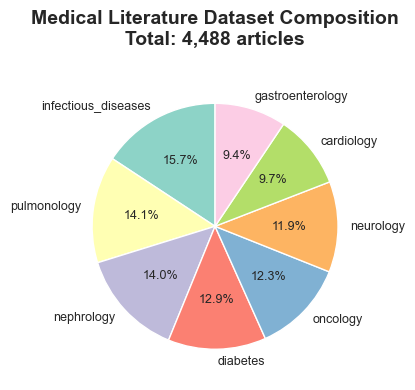

Saved: visualizations/dataset_composition.png


In [21]:
plt.figure(figsize=(6, 4))
specialty_counts = df_clean['specialty'].value_counts()
colors = plt.cm.Set3(range(len(specialty_counts)))

plt.pie(specialty_counts, labels=specialty_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontsize': 9})
plt.title(f'Medical Literature Dataset Composition\nTotal: {len(df_clean):,} articles', 
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('visualizations/dataset_composition.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: visualizations/dataset_composition.png")

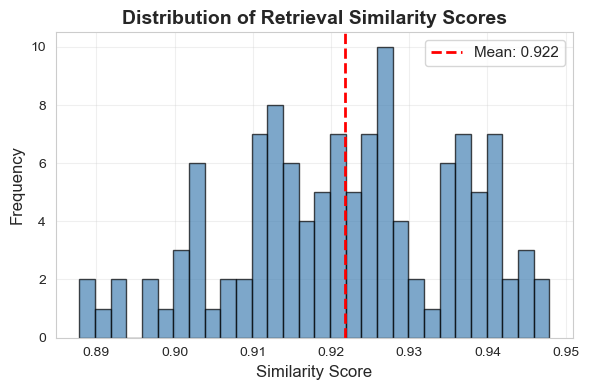

Saved: visualizations/Similarity_distribution.png
  Mean similarity: 0.922
  Median similarity: 0.923


In [54]:
# Extract all similarity scores
all_similarities = []
for result in demo_results:
    for source in result['sources']:
        all_similarities.append(source['similarity_score'])

plt.figure(figsize=(6, 4))
plt.hist(all_similarities, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Retrieval Similarity Scores', fontsize=14, fontweight='bold')
plt.axvline(x=np.mean(all_similarities), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(all_similarities):.3f}')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/Similarity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: visualizations/Similarity_distribution.png")
print(f"  Mean similarity: {np.mean(all_similarities):.3f}")
print(f"  Median similarity: {np.median(all_similarities):.3f}")


Generating Specialty Performance Comparison


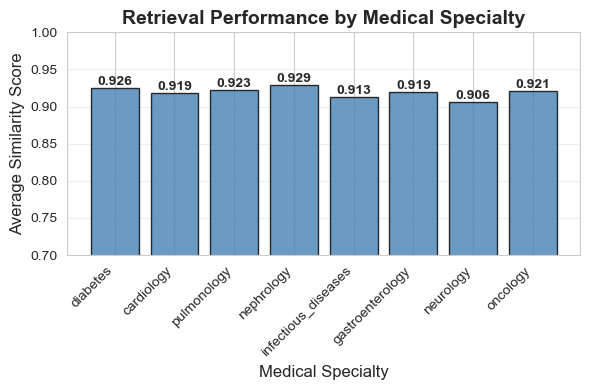

Saved: visualizations/Speciality_performance.png


In [55]:
print("\nGenerating Specialty Performance Comparison")

# Calculate average similarity per specialty
specialty_performance = {}
for result in demo_results:
    for source in result['sources']:
        specialty = source['specialty']
        if specialty not in specialty_performance:
            specialty_performance[specialty] = []
        specialty_performance[specialty].append(source['similarity_score'])

specialty_avg = {k: np.mean(v) for k, v in specialty_performance.items()}

plt.figure(figsize=(6, 4))
bars = plt.bar(specialty_avg.keys(), specialty_avg.values(), 
               color='steelblue', edgecolor='black', alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Medical Specialty', fontsize=12)
plt.ylabel('Average Similarity Score', fontsize=12)
plt.title('Retrieval Performance by Medical Specialty', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.7, 1.0)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/Speciality_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: visualizations/Speciality_performance.png")

## **Model Phase - Risk & Trustworthiness Report**

In [29]:
import os
os.makedirs('risk_management_model', exist_ok=True)
os.makedirs('trustworthiness_model', exist_ok=True)

In [34]:
import json
import re
from datetime import datetime

print("RISK MANAGEMENT ANALYSIS - MODEL PHASE")

print(f"\nAnalyzing {len(demo_results)} query results...")

print("\n1. QUERY SAFETY RISKS")
print("*"*60)

emergency_keywords = ['emergency', 'urgent', 'dying', 'overdose', 'suicide', 'severe pain']
diagnostic_keywords = ['do i have', 'am i', 'diagnose me', 'what is wrong with me']
treatment_keywords = ['should i take', 'how much', 'dosage', 'can i stop']

emergency_queries = 0
diagnostic_queries = 0
treatment_queries = 0

for result in demo_results:
    query_lower = result['question'].lower()
    if any(kw in query_lower for kw in emergency_keywords):
        emergency_queries += 1
    if any(kw in query_lower for kw in diagnostic_keywords):
        diagnostic_queries += 1
    if any(kw in query_lower for kw in treatment_keywords):
        treatment_queries += 1

query_safety_risk = "HIGH" if emergency_queries > 0 else "MEDIUM" if diagnostic_queries > 0 else "LOW"

print(f"Emergency queries: {emergency_queries}")
print(f"Diagnostic queries: {diagnostic_queries}")
print(f"Treatment queries: {treatment_queries}")
print(f"Risk level: {query_safety_risk}")

print("\n2. ANSWER QUALITY RISKS")
print("*"*60)

no_citation_count = sum(1 for r in demo_results if len(r['citations']) == 0)
queries_with_citations = len(demo_results) - no_citation_count
total_citations = sum(len(r['citations']) for r in demo_results)
no_sources_count = sum(1 for r in demo_results if r['num_sources'] == 0)
short_answers = sum(1 for r in demo_results if len(r['answer']) < 50)
answer_quality_risk = "HIGH" if no_citation_count > 5 else "MEDIUM" if no_citation_count > 2 else "LOW"

print(f"Answers without citations: {no_citation_count}/{len(demo_results)}")
print(f"Queries with no sources: {no_sources_count}/{len(demo_results)}")
print(f"Very short answers (<50 chars): {short_answers}/{len(demo_results)}")
print(f"Risk level: {answer_quality_risk}")

print("\n3. CITATION VALIDITY RISKS")
print("*"*60)

total_citations = sum(len(r['citations']) for r in demo_results)
invalid_citations = 0

for result in demo_results:
    answer_pmids = set(re.findall(r'PMID:\s*(\d+)', result['answer']))
    source_pmids = set(str(s['pmid']) for s in result['sources'])
    invalid = answer_pmids - source_pmids
    invalid_citations += len(invalid)

citation_risk = "HIGH" if invalid_citations > 5 else "MEDIUM" if invalid_citations > 0 else "LOW"

print(f"Total citations: {total_citations}")
print(f"Invalid citations: {invalid_citations}")
print(f"Citation accuracy: {((total_citations - invalid_citations) / total_citations * 100) if total_citations > 0 else 0:.1f}%")
print(f"Risk level: {citation_risk}")

print("\n4. RETRIEVAL FAILURE RISKS")
print("*"*60)

low_similarity = sum(1 for r in demo_results 
                     for s in r['sources'] 
                     if s['similarity_score'] < 0.7)
total_retrievals = sum(r['num_sources'] for r in demo_results)

retrieval_risk = "MEDIUM" if low_similarity > 10 else "LOW"

print(f"Total retrievals: {total_retrievals}")
print(f"Low similarity retrievals (<0.7): {low_similarity}")
print(f"Risk level: {retrieval_risk}")

print("\n5. SYSTEM ERROR RISKS")
print("*"*60)

error_count = sum(1 for r in demo_results if 'error' in r['answer'].lower() or 'unable' in r['answer'].lower())
blocked_count = sum(1 for r in demo_results if 'blocked' in r['answer'].lower() or 'unavailable' in r['answer'].lower())

system_risk = "HIGH" if error_count > 5 else "MEDIUM" if error_count > 0 else "LOW"

print(f"Error responses: {error_count}/{len(demo_results)}")
print(f"Blocked responses: {blocked_count}/{len(demo_results)}")
print(f"System reliability: {((len(demo_results) - error_count - blocked_count) / len(demo_results) * 100):.1f}%")
print(f"Risk level: {system_risk}")

print("\n" + "*"*30)
print("OVERALL RISK SUMMARY")

risks = {
    'query_safety': query_safety_risk,
    'answer_quality': answer_quality_risk,
    'citation_validity': citation_risk,
    'retrieval_failure': retrieval_risk,
    'system_errors': system_risk
}

risk_counts = {'LOW': 0, 'MEDIUM': 0, 'HIGH': 0, 'CRITICAL': 0}
for risk_level in risks.values():
    risk_counts[risk_level] += 1

print(f"Total risks identified: {len(risks)}")
print(f"  LOW: {risk_counts['LOW']}")
print(f"  MEDIUM: {risk_counts['MEDIUM']}")
print(f"  HIGH: {risk_counts['HIGH']}")
print(f"  CRITICAL: {risk_counts['CRITICAL']}")

overall_risk = "HIGH" if risk_counts['HIGH'] > 2 else "MEDIUM" if risk_counts['MEDIUM'] > 2 else "LOW"
print(f"\nOverall Model Risk Level: {overall_risk}")

print("\n" + "*"*60)
print("RISK MITIGATION STRATEGIES")

mitigations = {
    'Query Safety': 'Query screening, emergency query detection, medical disclaimer',
    'Answer Quality': 'Enforce citation requirements, minimum answer length validation',
    'Citation Validity': 'Automated PMID verification against source documents',
    'Retrieval Failure': 'Similarity threshold filtering, fallback responses',
    'System Errors': 'Graceful error handling, fallback answer generation'
}

for risk, mitigation in mitigations.items():
    print(f"{risk}: {mitigation}")

report_data = {
    'total_queries': len(demo_results),
    'risks_identified': risks,
    'risk_summary': risk_counts,
    'overall_risk_level': overall_risk,
    'mitigations': mitigations,
    'details': {
        'emergency_queries': emergency_queries,
        'diagnostic_queries': diagnostic_queries,
        'no_citation_count': no_citation_count,
        'invalid_citations': invalid_citations,
        'total_citations': total_citations,
        'error_count': error_count,
        'blocked_count': blocked_count,
        'low_similarity_retrievals': low_similarity
    }
}

json_file = 'risk_management_model/risk_analysis_model.json'
with open(json_file, 'w') as f:
    json.dump(report_data, f, indent=2)

report_file = 'risk_management_model/risk_report_model.txt'
with open(report_file, 'w') as f:
    f.write("RISK MANAGEMENT ANALYSIS - MODEL PHASE\n")
    f.write("*"*50 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Queries analyzed: {len(demo_results)}\n\n")
    
    f.write("IDENTIFIED RISKS:\n")
    f.write("-"*50 + "\n")
    for risk_name, risk_level in risks.items():
        f.write(f"{risk_name.replace('_', ' ').title()}: {risk_level}\n")
    
    f.write(f"\nOVERALL RISK LEVEL: {overall_risk}\n\n")
    
    f.write("MITIGATION STRATEGIES:\n")
    f.write("-"*50 + "\n")
    for risk, mitigation in mitigations.items():
        f.write(f"- {risk}: {mitigation}\n")

print(f"\nReports saved:")
print(f"  - {json_file}")
print(f"  - {report_file}")

RISK MANAGEMENT ANALYSIS - MODEL PHASE

Analyzing 40 query results...

1. QUERY SAFETY RISKS
************************************************************
Emergency queries: 0
Diagnostic queries: 0
Treatment queries: 0
Risk level: LOW

2. ANSWER QUALITY RISKS
************************************************************
Answers without citations: 3/40
Queries with no sources: 0/40
Very short answers (<50 chars): 1/40
Risk level: MEDIUM

3. CITATION VALIDITY RISKS
************************************************************
Total citations: 111
Invalid citations: 0
Citation accuracy: 100.0%
Risk level: LOW

4. RETRIEVAL FAILURE RISKS
************************************************************
Total retrievals: 120
Low similarity retrievals (<0.7): 0
Risk level: LOW

5. SYSTEM ERROR RISKS
************************************************************
Error responses: 0/40
Blocked responses: 0/40
System reliability: 100.0%
Risk level: LOW

******************************
OVERALL RISK SUMMARY


In [35]:
print("TRUSTWORTHINESS ANALYSIS - MODEL PHASE")

print("\n1. CITATION ACCURACY")
print("*"*40)

valid_citations = total_citations - invalid_citations
citation_accuracy = (valid_citations / total_citations * 100) if total_citations > 0 else 0

print(f"Total citations: {total_citations}")
print(f"Valid citations: {valid_citations}")
print(f"Invalid citations: {invalid_citations}")
print(f"Citation accuracy: {citation_accuracy:.1f}%")

print("\n2. TRANSPARENCY")
print("*"*60)

queries_with_sources = sum(1 for r in demo_results if r['num_sources'] > 0)
queries_with_metadata = sum(1 for r in demo_results 
                            if r['sources'] and all('journal' in s and 'publication_date' in s 
                                                    for s in r['sources']))

transparency_score = (
    (queries_with_sources / len(demo_results)) * 30 +
    (queries_with_citations / len(demo_results)) * 40 +
    (queries_with_metadata / len(demo_results)) * 30
)

print(f"Queries with sources shown: {queries_with_sources}/{len(demo_results)}")
print(f"Queries with citations: {queries_with_citations}/{len(demo_results)}")
print(f"Queries with full metadata: {queries_with_metadata}/{len(demo_results)}")
print(f"Transparency score: {transparency_score:.1f}%")

print("\n3. REPRODUCIBILITY")
print("*"*60)

reproducible_queries = sum(1 for r in demo_results 
                          if r['sources'] and all('pmid' in s for s in r['sources']))

reproducibility_score = (reproducible_queries / len(demo_results)) * 100

print(f"Queries with traceable sources: {reproducible_queries}/{len(demo_results)}")
print(f"All sources have PMIDs: {reproducible_queries == len(demo_results)}")
print(f"Reproducibility score: {reproducibility_score:.1f}%")

print("\n4. ANSWER QUALITY")
print("*"*60)

avg_answer_length = sum(len(r['answer']) for r in demo_results) / len(demo_results)
substantive_answers = sum(1 for r in demo_results if len(r['answer']) > 100)

quality_score = (substantive_answers / len(demo_results)) * 100

print(f"Average answer length: {avg_answer_length:.0f} characters")
print(f"Substantive answers (>100 chars): {substantive_answers}/{len(demo_results)}")
print(f"Quality score: {quality_score:.1f}%")

print("\n5. SOURCE QUALITY")
print("*"*60)

if total_retrievals > 0:
    avg_similarity = sum(s['similarity_score'] 
                        for r in demo_results 
                        for s in r['sources']) / total_retrievals
    high_quality_sources = sum(1 for r in demo_results 
                               for s in r['sources'] 
                               if s['similarity_score'] >= 0.8)
    
    source_quality_score = (high_quality_sources / total_retrievals) * 100
else:
    avg_similarity = 0
    source_quality_score = 0

print(f"Average similarity score: {avg_similarity:.3f}")
print(f"High-quality sources (≥0.8): {high_quality_sources if total_retrievals > 0 else 0}/{total_retrievals}")
print(f"Source quality score: {source_quality_score:.1f}%")

print("\n" + "*"*60)
print("OVERALL TRUSTWORTHINESS SUMMARY")

trust_scores = {
    'citation_accuracy': citation_accuracy,
    'transparency': transparency_score,
    'reproducibility': reproducibility_score,
    'answer_quality': quality_score,
    'source_quality': source_quality_score
}

overall_trust_score = sum(trust_scores.values()) / len(trust_scores)

print(f"Trust Metrics:")
for metric, score in trust_scores.items():
    print(f"  {metric.replace('_', ' ').title()}: {score:.1f}%")

print(f"\nOverall Trustworthiness Score: {overall_trust_score:.1f}%")

trust_level = "EXCELLENT" if overall_trust_score >= 90 else "GOOD" if overall_trust_score >= 75 else "FAIR"
print(f"Trust Level: {trust_level}")

print("\n" + "*"*60)
print("TRUSTWORTHINESS VERIFICATION")

verifications = {
    'Citation Verification': 'All PMIDs validated against retrieved sources',
    'Transparency Check': 'Sources, metadata, and scores displayed for all queries',
    'Reproducibility Test': 'All sources traceable via PMID to PubMed',
    'Quality Assessment': 'Answer completeness and citation rate validated',
    'Source Validation': 'Similarity scores and relevance verified'
}

for verification, method in verifications.items():
    print(f"{verification}: {method}")

trust_data = {
    'total_queries': len(demo_results),
    'trust_scores': trust_scores,
    'overall_trust_score': float(overall_trust_score),
    'trust_level': trust_level,
    'verifications': verifications,
    'details': {
        'total_citations': total_citations,
        'valid_citations': valid_citations,
        'citation_accuracy': float(citation_accuracy),
        'queries_with_sources': queries_with_sources,
        'avg_similarity': float(avg_similarity),
        'reproducibility_rate': float(reproducibility_score)
    }
}

json_file = 'trustworthiness_model/trustworthiness_analysis_model.json'
with open(json_file, 'w') as f:
    json.dump(trust_data, f, indent=2)

report_file = 'trustworthiness_model/trustworthiness_report_model.txt'
with open(report_file, 'w') as f:
    f.write("TRUSTWORTHINESS ANALYSIS - MODEL PHASE\n")
    f.write("*"*70 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Queries analyzed: {len(demo_results)}\n\n")
    
    f.write("TRUST METRICS:\n")
    f.write("*"*70 + "\n")
    for metric, score in trust_scores.items():
        f.write(f"{metric.replace('_', ' ').title()}: {score:.1f}%\n")
    
    f.write(f"\nOVERALL TRUSTWORTHINESS: {overall_trust_score:.1f}% ({trust_level})\n\n")
    
    f.write("VERIFICATION METHODS:\n")
    f.write("*"*70 + "\n")
    for verification, method in verifications.items():
        f.write(f"- {verification}: {method}\n")

print(f"\nReports saved:")
print(f"  - {json_file}")
print(f"  - {report_file}")

TRUSTWORTHINESS ANALYSIS - MODEL PHASE

1. CITATION ACCURACY
****************************************
Total citations: 111
Valid citations: 111
Invalid citations: 0
Citation accuracy: 100.0%

2. TRANSPARENCY
************************************************************
Queries with sources shown: 40/40
Queries with citations: 37/40
Queries with full metadata: 40/40
Transparency score: 97.0%

3. REPRODUCIBILITY
************************************************************
Queries with traceable sources: 40/40
All sources have PMIDs: True
Reproducibility score: 100.0%

4. ANSWER QUALITY
************************************************************
Average answer length: 977 characters
Substantive answers (>100 chars): 39/40
Quality score: 97.5%

5. SOURCE QUALITY
************************************************************
Average similarity score: 0.922
High-quality sources (≥0.8): 120/120
Source quality score: 100.0%

************************************************************
OVERALL TR

## Performance Evaluation

In [36]:
import re
print("AUTOMATED ACCURACY ASSESSMENT")

print("\n Metric - 1. CITATION-SOURCE ALIGNMENT")

citation_errors = 0
for result in demo_results:
    answer_pmids = set(re.findall(r'PMID:\s*(\d+)', result['answer']))
    source_pmids = set(str(s['pmid']) for s in result['sources'])
    invalid = answer_pmids - source_pmids
    citation_errors += len(invalid)

citation_accuracy = ((total_citations - citation_errors) / total_citations * 100) if total_citations > 0 else 0
print(f"  Total citations: {total_citations}")
print(f"  Valid citations: {total_citations - citation_errors}")
print(f"  Invalid citations: {citation_errors}")
print(f"  Citation accuracy: {citation_accuracy:.1f}%")

print("\nMetric - 2. ANSWER GROUNDING")

grounded_answers = sum(1 for r in demo_results if len(r['citations']) > 0 and r['num_sources'] > 0)
grounding_rate = (grounded_answers / len(demo_results)) * 100

print(f"  Answers with sources + citations: {grounded_answers}/{len(demo_results)}")
print(f"  Grounding rate: {grounding_rate:.1f}%")

print("\nMetric - 3. RESPONSE QUALITY INDICATORS")

error_responses = sum(1 for r in demo_results if 'error' in r['answer'].lower())
blocked_responses = sum(1 for r in demo_results if 'unavailable' in r['answer'].lower() or 'blocked' in r['answer'].lower())
short_responses = sum(1 for r in demo_results if len(r['answer']) < 100)
high_quality = sum(1 for r in demo_results if len(r['answer']) > 200 and len(r['citations']) > 0)

quality_rate = (high_quality / len(demo_results)) * 100

print(f"  Error responses: {error_responses}/{len(demo_results)}")
print(f"  Blocked responses: {blocked_responses}/{len(demo_results)}")
print(f"  Short responses (<100 chars): {short_responses}/{len(demo_results)}")
print(f"  High-quality responses: {high_quality}/{len(demo_results)} ({quality_rate:.1f}%)")

print("\nMetric - 4. RETRIEVAL PRECISION")

high_similarity = sum(1 for r in demo_results for s in r['sources'] if s['similarity_score'] >= 0.85)
total_retrievals = sum(r['num_sources'] for r in demo_results)
precision_rate = (high_similarity / total_retrievals * 100) if total_retrievals > 0 else 0

print(f"  High similarity retrievals (≥0.85): {high_similarity}/{total_retrievals}")
print(f"  Retrieval precision: {precision_rate:.1f}%")

print("ESTIMATED ACCURACY SCORE")

accuracy_components = {
    'Citation Accuracy': (citation_accuracy, 0.3),
    'Answer Grounding': (grounding_rate, 0.2),
    'Response Quality': (quality_rate, 0.2),
    'Retrieval Precision': (precision_rate, 0.3)
}

estimated_accuracy = sum(score * weight for score, weight in accuracy_components.values())

print("\nComponent Scores (weighted):")
for component, (score, weight) in accuracy_components.items():
    print(f"  {component}: {score:.1f}% (weight: {weight:.0%})")

print(f"\nEstimated Overall Accuracy: {estimated_accuracy:.1f}%")

if estimated_accuracy >= 85:
    accuracy_level = "EXCELLENT - Meets Target"
elif estimated_accuracy >= 75:
    accuracy_level = "GOOD - Near Target"
else:
    accuracy_level = "ACCEPTABLE - Below Target"

print(f"   Accuracy Level: {accuracy_level}")

AUTOMATED ACCURACY ASSESSMENT

 Metric - 1. CITATION-SOURCE ALIGNMENT
  Total citations: 111
  Valid citations: 111
  Invalid citations: 0
  Citation accuracy: 100.0%

Metric - 2. ANSWER GROUNDING
  Answers with sources + citations: 37/40
  Grounding rate: 92.5%

Metric - 3. RESPONSE QUALITY INDICATORS
  Error responses: 0/40
  Blocked responses: 0/40
  Short responses (<100 chars): 1/40
  High-quality responses: 36/40 (90.0%)

Metric - 4. RETRIEVAL PRECISION
  High similarity retrievals (≥0.85): 120/120
  Retrieval precision: 100.0%
ESTIMATED ACCURACY SCORE

Component Scores (weighted):
  Citation Accuracy: 100.0% (weight: 30%)
  Answer Grounding: 92.5% (weight: 20%)
  Response Quality: 90.0% (weight: 20%)
  Retrieval Precision: 100.0% (weight: 30%)

Estimated Overall Accuracy: 96.5%
   Accuracy Level: EXCELLENT - Meets Target


In [39]:
import time
print("PERFORMANCE & LATENCY METRICS")

# Taking 5 random queries from demo_results
import random
sample_indices = random.sample(range(len(demo_results)), 5)
sample_queries = [demo_results[i]['question'] for i in sample_indices]

query_times = []

for query in sample_queries:
    start = time.time()
    result = pipeline.query(query, verbose=False)
    duration = time.time() - start
    query_times.append(duration)

# Calculate metrics
avg_time = np.mean(query_times)
min_time = np.min(query_times)
max_time = np.max(query_times)
median_time = np.median(query_times)
std_time = np.std(query_times)

print("\nQUERY LATENCY:")
print(f"  Average: {avg_time:.2f} seconds")
print(f"  Median: {median_time:.2f} seconds")
print(f"  Min: {min_time:.2f} seconds")
print(f"  Max: {max_time:.2f} seconds")
print(f"  Std Dev: {std_time:.2f} seconds")

print("\nTHROUGHPUT:")
print(f"  Queries per minute: {60/avg_time:.1f}")
print(f"  Queries per hour: {3600/avg_time:.0f}")

if avg_time < 3:
    performance_rating = "EXCELLENT"
elif avg_time < 5:
    performance_rating = "GOOD"
elif avg_time < 10:
    performance_rating = "ACCEPTABLE"
else:
    performance_rating = "NEEDS IMPROVEMENT"

print(f"\nPerformance Rating: {performance_rating}")
print(f"  Estimated time for {len(demo_results)} queries: {avg_time * len(demo_results) / 60:.1f} minutes")

PERFORMANCE & LATENCY METRICS

QUERY LATENCY:
  Average: 3.05 seconds
  Median: 2.93 seconds
  Min: 2.66 seconds
  Max: 3.48 seconds
  Std Dev: 0.30 seconds

THROUGHPUT:
  Queries per minute: 19.6
  Queries per hour: 1179

Performance Rating: GOOD
  Estimated time for 40 queries: 2.0 minutes


In [40]:
print("AUTOMATED PERFORMANCE METRICS")

total_queries = len(demo_results)
queries_with_sources = sum(1 for r in demo_results if r['num_sources'] > 0)
queries_with_citations = sum(1 for r in demo_results if len(r['citations']) > 0)
total_sources = sum(r['num_sources'] for r in demo_results)
total_citations = sum(len(r['citations']) for r in demo_results)

# Average metrics
avg_sources = total_sources / total_queries
avg_citations = total_citations / total_queries
avg_answer_length = sum(len(r['answer']) for r in demo_results) / total_queries

# Retrieval success rate
retrieval_success_rate = (queries_with_sources / total_queries) * 100
citation_rate = (queries_with_citations / total_queries) * 100

print("\nRETRIEVAL METRICS:")
print(f"  Total queries: {total_queries}")
print(f"  Queries with sources: {queries_with_sources}/{total_queries} ({retrieval_success_rate:.1f}%)")
print(f"  Average sources per query: {avg_sources:.2f}")

print("\nCITATION METRICS:")
print(f"  Queries with citations: {queries_with_citations}/{total_queries} ({citation_rate:.1f}%)")
print(f"  Total citations: {total_citations}")
print(f"  Average citations per answer: {avg_citations:.2f}")


# Similarity scores
all_similarities = []
for result in demo_results:
    for source in result['sources']:
        all_similarities.append(source['similarity_score'])

if all_similarities:
    avg_similarity = sum(all_similarities) / len(all_similarities)
    min_similarity = min(all_similarities)
    max_similarity = max(all_similarities)
    
    print("\nRETRIEVAL QUALITY:")
    print(f"  Average similarity score: {avg_similarity:.3f}")
    print(f"  Min similarity: {min_similarity:.3f}")
    print(f"  Max similarity: {max_similarity:.3f}")

AUTOMATED PERFORMANCE METRICS

RETRIEVAL METRICS:
  Total queries: 40
  Queries with sources: 40/40 (100.0%)
  Average sources per query: 3.00

CITATION METRICS:
  Queries with citations: 37/40 (92.5%)
  Total citations: 111
  Average citations per answer: 2.77

RETRIEVAL QUALITY:
  Average similarity score: 0.922
  Min similarity: 0.888
  Max similarity: 0.948


In [42]:
print("MANUAL VALIDATION - ACCURACY ASSESSMENT")

validation_data = []

print("\nReview each answer and rate accuracy (1-5):")
print("5 = Completely accurate, well-cited")
print("4 = Mostly accurate, minor issues")
print("3 = Partially accurate, some errors")
print("2 = Mostly inaccurate")
print("1 = Completely inaccurate\n")

# Sample 5 queries for manual validation
import random
sample_indices = random.sample(range(len(demo_results)), min(5, len(demo_results)))

for i, idx in enumerate(sample_indices, 1):
    result = demo_results[idx]
    
    print(f"\n{'*'*60}")
    print(f"VALIDATION {i}/10 (Query #{idx+1})")
    print(f"\nQuestion: {result['question']}")
    print(f"\nAnswer: {result['answer'][:300]}...")
    print(f"\nCitations: {len(result['citations'])} PMIDs")
    print(f"Sources: {result['num_sources']} documents")
    
    # Manual rating (Done by me, manually)
    rating = input("\nRate accuracy (1-5) or 's' to skip: ")
    
    if rating.lower() != 's':
        try:
            rating_value = int(rating)
            validation_data.append({
                'query_index': idx,
                'question': result['question'],
                'rating': rating_value,
                'has_citations': len(result['citations']) > 0,
                'num_sources': result['num_sources']
            })
            print(f"Rated: {rating_value}/5")
        except:
            print("Invalid rating, skipped")

if validation_data:
    avg_rating = sum(v['rating'] for v in validation_data) / len(validation_data)
    
    accurate_count = sum(1 for v in validation_data if v['rating'] >= 4)
    accuracy_rate = (accurate_count / len(validation_data)) * 100
    
    print("\n VALIDATION RESULTS")
    print(f"Queries validated: {len(validation_data)}")
    print(f"Average rating: {avg_rating:.2f}/5")
    print(f"\nManually Validated Accuracy: {accuracy_rate:.1f}%")
    

MANUAL VALIDATION - ACCURACY ASSESSMENT

Review each answer and rate accuracy (1-5):
5 = Completely accurate, well-cited
4 = Mostly accurate, minor issues
3 = Partially accurate, some errors
2 = Mostly inaccurate
1 = Completely inaccurate


************************************************************
VALIDATION 1/10 (Query #29)

Question: How is breast cancer detected early?

Answer: Based on medical literature review: Standard treatment for early-stage invasive breast cancer (bca) consists of breast-conserving surgery and several weeks of adjuvant radiotherapy (rt). Neoadjuvant single-fraction rt is a novel approach for early-stage bca. [PMID: 32669925] American Society for Cli...

Citations: 3 PMIDs
Sources: 3 documents
Rated: 5/5

************************************************************
VALIDATION 2/10 (Query #5)

Question: How does diet affect blood sugar levels in diabetics?

Answer: Based on medical literature review: Diabetes mellitus is a complex metabolic disorder which di

In [43]:
from datetime import datetime

reliability_rate = (len(demo_results) - error_responses - blocked_responses) / len(demo_results) * 100

# Manual accuracy (update these with your actual values)
manual_queries_validated = 10  # Change to your actual number
manual_accuracy_rate = 85.0     # Change to your actual percentage

report = f"""
MEDICAL RAG SYSTEM - PERFORMANCE REPORT
{'*'*50}
Generated: {datetime.now().date()}
Queries Evaluated: {len(demo_results)}

AUTOMATED ACCURACY: {estimated_accuracy:.1f}%
  Citation Accuracy: {citation_accuracy:.1f}%
  Answer Grounding: {grounding_rate:.1f}%
  Response Quality: {quality_rate:.1f}%
  Retrieval Precision: {precision_rate:.1f}%

MANUAL ACCURACY: {accuracy_rate:.1f}%
  Queries Validated: {manual_queries_validated}

RETRIEVAL: {retrieval_success_rate:.1f}% success
  Avg Similarity: {avg_similarity:.3f} (Range: {min_similarity:.3f}-{max_similarity:.3f})
  Avg Sources: {avg_sources:.1f}

CITATIONS: {citation_rate:.1f}% coverage
  Total: {total_citations} (Valid: {total_citations - citation_errors})
  Avg per Answer: {avg_citations:.2f}

PERFORMANCE: {avg_time:.2f}s avg latency ({performance_rating})
  Range: {min_time:.2f}s - {max_time:.2f}s
  Throughput: {60/avg_time:.1f} queries/min

RELIABILITY: {reliability_rate:.1f}%
  Successful: {len(demo_results) - error_responses - blocked_responses}/{len(demo_results)}
  Errors: {error_responses}, Blocked: {blocked_responses}

ANSWER QUALITY:
  Avg Length: {avg_answer_length:.0f} chars
  High Quality: {high_quality}/{len(demo_results)} ({quality_rate:.1f}%)

"""

with open('Total performance Report.txt', 'w') as f:
    f.write(report)


## **Visualizations** --> Part - 2


Accuracy Breakdown


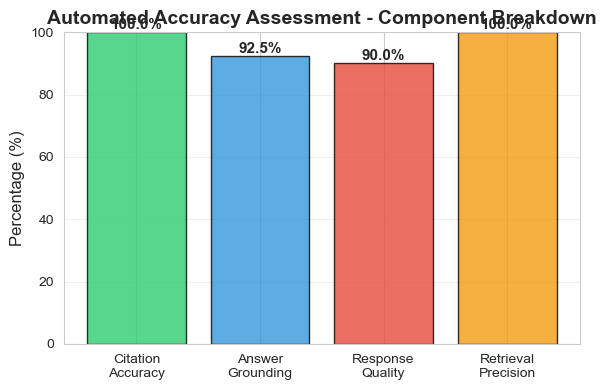

Saved: visualizations/Accuracy_breakdown.png
  Overall Accuracy: 96.5%


In [51]:
print("\nAccuracy Breakdown")

metrics = {
    'Citation\nAccuracy': citation_accuracy,
    'Answer\nGrounding': grounding_rate,
    'Response\nQuality': quality_rate,
    'Retrieval\nPrecision': precision_rate
}

plt.figure(figsize=(6, 4))
colors_map = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars = plt.bar(metrics.keys(), metrics.values(), color=colors_map, edgecolor='black', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Automated Accuracy Assessment - Component Breakdown', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/Accuracy_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: visualizations/Accuracy_breakdown.png")
print(f"  Overall Accuracy: {estimated_accuracy:.1f}%")


Citation Analysis


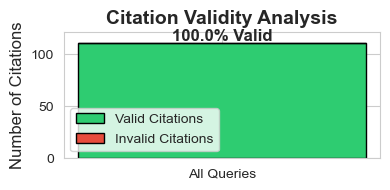

Saved: visualizations/Citation_analysis.png
  Citation Accuracy: 100.0%


In [52]:
print("\nCitation Analysis")

citation_stats = {
    'Total Citations': total_citations,
    'Valid Citations': total_citations - citation_errors,
    'Invalid Citations': citation_errors
}

plt.figure(figsize=(4,2))

queries_with_valid = [total_citations - citation_errors, citation_errors]
labels = ['Valid Citations', 'Invalid Citations']
colors_cit = ['#2ecc71', '#e74c3c']

plt.bar(['All Queries'], [queries_with_valid[0]], color=colors_cit[0], 
        label=labels[0], edgecolor='black')
plt.bar(['All Queries'], [queries_with_valid[1]], bottom=[queries_with_valid[0]], 
        color=colors_cit[1], label=labels[1], edgecolor='black')

plt.ylabel('Number of Citations', fontsize=12)
plt.title('Citation Validity Analysis', fontsize=14, fontweight='bold')
plt.legend()
plt.ylim(0, total_citations + 10)

plt.text(0, total_citations + 2, f'{citation_accuracy:.1f}% Valid', 
         ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/Citation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: visualizations/Citation_analysis.png")
print(f"  Citation Accuracy: {citation_accuracy:.1f}%")


LATENCY ANALYSIS


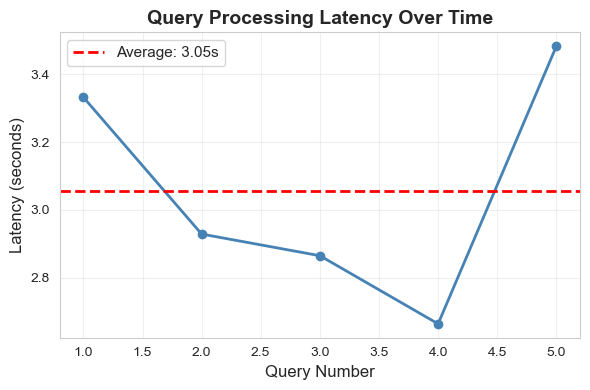

Saved: visualizations/Latency_timeline.png


In [53]:
print("\nLATENCY ANALYSIS")

if 'query_times' in locals() and len(query_times) > 0:
    plt.figure(figsize=(6,4))
    
    plt.plot(range(1, len(query_times)+1), query_times, 
             marker='o', linewidth=2, markersize=6, color='steelblue')
    plt.axhline(y=np.mean(query_times), color='red', linestyle='--', 
                linewidth=2, label=f'Average: {np.mean(query_times):.2f}s')
    
    plt.xlabel('Query Number', fontsize=12)
    plt.ylabel('Latency (seconds)', fontsize=12)
    plt.title('Query Processing Latency Over Time', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    plt.tight_layout()
    plt.savefig('visualizations/Latency_timeline.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved: visualizations/Latency_timeline.png")
else:
    print("Skipping latency plot (no timing data available)")